<img style="float:right" width="25%" src="EscudoColorTc.jpg">
<h1 style="display: inline-block; padding: 4mm; padding-left= 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px">

    Práctica 5: Recomendación basada en modelos
</h1>

## Gestión de la Información. Curso 2025-2026

## Alumnos:
* Belén Rodríguez Cánovas
* Fernando Arroyo Redondo
___

# 1 Instalación de surprise por medio del terminal de anaconda con derechos de administrador
## Se introduce la instrucción conda install -c conda-forge scikit-surprise

Surprise requiere python 3.10.x no funciona con versiones inferiores o superiores.
Se adpata también en consola, instalando un nuevo entron envsurprise con python 3.10.
después de activar el nuevo entorno se carga ipykernel
Finalmente, se cambia el entorno en Cambiar Kernel
Se instala también seaborn en consola con el comando conda install seaborn -c conda-forge
para permitir el análisis de los resultados obtenidos después de entrenar y comprobar con surprise

# 2 Instalación de librerías necesarias

In [1]:
# Importación de módulos especificos de surprise
from surprise import Dataset, Reader
from surprise import accuracy as surprise_accuracy
from surprise import SVD, KNNBasic
from surprise.model_selection import train_test_split, cross_validate

# Importación de otras liberías útiles
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
import heapq
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
from collections import defaultdict

# 3 Importación de datos de movilens
## Para mayor simplicidad se ha importado los datos en el fichero dataset.csv con los campos siguientes:
* userId
* movieId
* Title
* rating

In [ ]:
#df = pd.read_csv('dataset.csv', on_bad_lines='warn', skiprows=lambda i: i>0 and random.random() > 0.001)
df = pd.read_csv('dataset.csv', sep= ';')
print(df[:4])
print(df.columns)
print(len(df))

In [ ]:
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(df[['userId','movieId','rating']],reader)
print(type(data))
#reader = Reader(line_format='user item rating', sep=';')
#data = Dataset.load_from_file('dataset.csv', reader=reader)

In [4]:
# Crear un dataframe con los datos
df = pd.read_csv('dataset.csv',sep=';')

#Chequear extracción
print(df[:4])
print(df.shape)

   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
(100836, 3)


# 4 División del fichero entre entrenamiento y test

In [5]:
# Lextura de datos para tratmiento por surprise
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(df[['userId','movieId','rating']],reader)

#chequeo de la acción
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


In [6]:
    # test_size=0.2 significa que 20%  de los datos servirá para el test
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    print(f"\nTraining set size: {len(list(trainset.all_ratings()))}")
    print(f"Test set size: {len(testset)}")


Training set size: 80668
Test set size: 20168


# 5 Entrenamiento del modelo SVD

In [7]:
    print("\n Entrenando al modelo SVD...")
    
    svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
    svd.fit(trainset)


 Entrenando al modelo SVD...


# 6 Evaluación del modelo en el set de test

In [8]:
    predictions = svd.test(testset)
    rmse = surprise_accuracy.rmse(predictions)
    mae = surprise_accuracy.mae(predictions)
    
    print(f"Evaluación del modelo en el set de test:")
    print(f"RMSE: {rmse:.4f}") # RMSE (Root Mean Square Error): valores bajos indican un mejor resultado
    print(f"MAE: {mae:.4f}") # MAE (Mean Absolute Error): medida de la exactitud de la predicción

RMSE: 0.8803
MAE:  0.6773
Evaluación del modelo en el set de test:
RMSE: 0.8803
MAE: 0.6773


# 7 Función para obtener las N mejores recomendaciones para un usuario

In [9]:
    def get_top_n_recommendations(predictions, n=10):
        """Devuelve las n mejores recomendaciones para cada usuario
        en este caso las 10 mejores"""
        # Diccionario con las predicciones para cada usuario
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est))
            
        # Se ordenan las predicciones para cada usuario y se encuentran las mejores
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
            
        return top_n

# 8 Función para generar recomendaciones para un usuario

In [10]:
    
    def recommend_for_user(user_id, n=10):
        """Crea n recommendaciones para un usuario espedífico"""
        # Obtener la lista de todos los identificadores de películas
        all_movie_ids = ratings_df['movieId'].unique()
        
        # Obeter los identificadores de las películas que el usuario ya ha visto
        user_rated_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
        
        # Identificadores de las películas que el usuario no ha visto para hacer predicciones
        movies_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movies]
        
        # Hacer predicciones
        predictions = [svd.predict(user_id, movie_id) for movie_id in movies_to_predict]
        
        # Ordenar las predicciones usanto evaluaciones estimadas
        predictions.sort(key=lambda x: x.est, reverse=True)
        
        # Guardar las n mejores y devolverlas
        top_recommendations = predictions[:n]
        
        return top_recommendations

# 9 Predicción para un usuario determinado 

In [11]:
    ratings_df = df
    # Escoger un usuario del dataset
    sample_user = ratings_df['userId'].iloc[0]
    print(f"\nGenerando recommendaciones para el user {sample_user}...")
    movie_titles = {}
    recommendations = recommend_for_user(sample_user, n=10)
    
    print(f"\n 10 películas recommendadas para el usuario {sample_user}:")
    for i, rec in enumerate(recommendations, 1):
        movie_id = rec.iid
        predicted_rating = rec.est
        title = movie_titles.get(movie_id, f"Identificador de la película: {movie_id}")
        print(f"{i}. {title} (Evaluación prevista: {predicted_rating:.2f})")
    


Generando recommendaciones para el user 1...

 10 películas recommendadas para el usuario 1:
1. Identificador de la película: 318 (Evaluación prevista: 5.00)
2. Identificador de la película: 112552 (Evaluación prevista: 5.00)
3. Identificador de la película: 904 (Evaluación prevista: 5.00)
4. Identificador de la película: 908 (Evaluación prevista: 5.00)
5. Identificador de la película: 4226 (Evaluación prevista: 5.00)
6. Identificador de la película: 541 (Evaluación prevista: 5.00)
7. Identificador de la película: 1223 (Evaluación prevista: 5.00)
8. Identificador de la película: 1204 (Evaluación prevista: 5.00)
9. Identificador de la película: 1172 (Evaluación prevista: 5.00)
10. Identificador de la película: 5902 (Evaluación prevista: 4.98)


# 10 Archivar el modelo para usos futuros

In [13]:
    import pickle
    with open('svd_model.pkl', 'wb') as file:
        pickle.dump(svd, file)
    
    print("\nModelo guardado como 'svd_model.pkl'")


Modelo guardado como 'svd_model.pkl'


# 11 Añadir un nuevo usuario para efectuar recomendaciones

In [14]:
nuevo_df = df
nuevo_df.loc[100837] = ['611','1','4.7']
nuevo_df.loc[100838] = ['611','552','4.3']
nuevo_df.loc[100839] = ['611','88267','4.5']
nuevo_df.loc[100840] = ['611','1270','4.0']
nuevo_df.loc[100841] = ['611','59614','4.0']
nuevo_df.loc[100842] = ['611','30793','4.5']


print (nuevo_df[100837:100842])


       userId movieId rating
100838    611     552    4.3
100839    611   88267    4.5
100840    611    1270    4.0
100841    611   59614    4.0
100842    611   30793    4.5


In [15]:
# Escoger el usuario añadido al dataset
sample_user = nuevo_df['userId'].iloc[611]
print(f"\nGenerando recommendaciones para el user {sample_user}...")
movie_titles = {}
recommendations = recommend_for_user(sample_user, n=10)
    
print(f"\n 10 películas recommendadas para el usuario {sample_user}:")
for i, rec in enumerate(recommendations, 1):
    movie_id = rec.iid
    predicted_rating = rec.est
    title = movie_titles.get(movie_id, f"Identificador de la película: {movie_id}")
    print(f"{i}. {title} (Evaluación prevista: {predicted_rating:.2f})")
    


Generando recommendaciones para el user 6...

 10 películas recommendadas para el usuario 6:
1. Identificador de la película: 2571 (Evaluación prevista: 4.95)
2. Identificador de la película: 260 (Evaluación prevista: 4.72)
3. Identificador de la película: 1204 (Evaluación prevista: 4.69)
4. Identificador de la película: 5952 (Evaluación prevista: 4.65)
5. Identificador de la película: 3435 (Evaluación prevista: 4.61)
6. Identificador de la película: 58559 (Evaluación prevista: 4.59)
7. Identificador de la película: 1197 (Evaluación prevista: 4.59)
8. Identificador de la película: 1945 (Evaluación prevista: 4.58)
9. Identificador de la película: 7153 (Evaluación prevista: 4.56)
10. Identificador de la película: 2959 (Evaluación prevista: 4.55)


# 12. Análisis usuarios

Media general de las evaluaciones: 3.66
Número de usuarios con las evaluaciones por encima de la media general: 326

 Los 10 usuarios con las medias de evaluación más elevada:
     user_id  avg_rating
385       53    5.000000
372      251    4.857143
545      515    4.857143
357       25    4.805556
308      523    4.716667
479      348    4.700000
204       30    4.689655
423      171    4.666667
587      547    4.583333
102       43    4.569892

Número de usuarios con las evaluaciones por debajo de la media general: 284

 Los 10 usuarios con las medias de evaluación más bajas:
     user_id  avg_rating
388      442    1.166667
455      508    2.075000
51       139    2.182119
270      153    2.231618
91         3    2.242424
10       567    2.265886
474      255    2.354839
192      517    2.366154
99       298    2.396414
602      311    2.404762



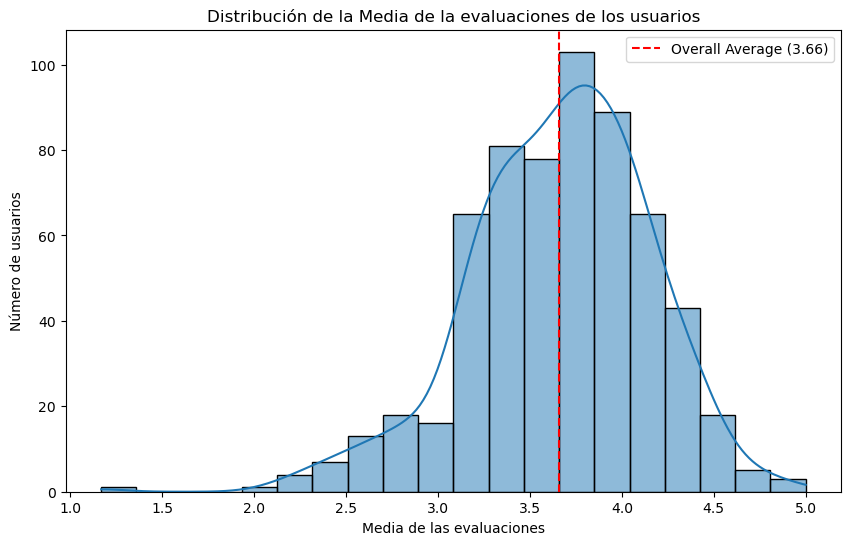

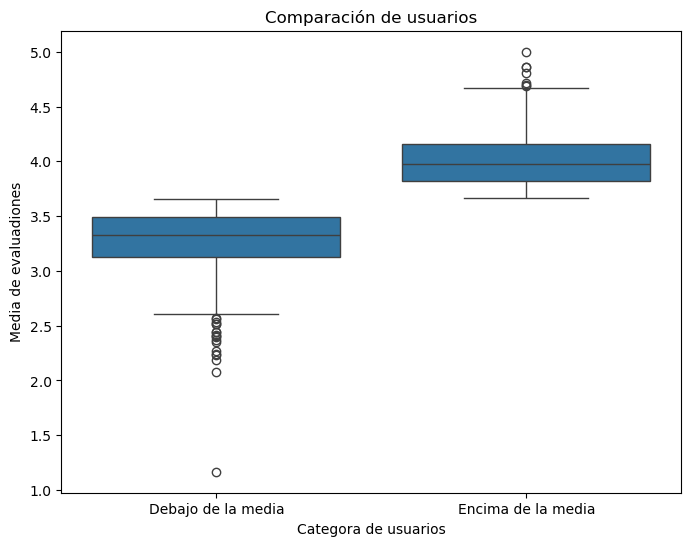

In [16]:
# Creación de un diccionario para almacenar los datos necesarios
user_ratings = defaultdict(list)

# Recolectar todas las evaluaciones por usuario
for uid, iid, rating in trainset.all_ratings():
    # Convert internal ids to raw ids if needed
    raw_uid = trainset.to_raw_uid(uid)
    user_ratings[raw_uid].append(rating)

# Calcular la media de evaluaciones por usuario
user_avg_ratings = {user: np.mean(ratings) for user, ratings in user_ratings.items()}

# Convertir en DataFrame los resultados para facilitar el análisis
user_ratings_df = pd.DataFrame({
    'user_id': list(user_avg_ratings.keys()),
    'avg_rating': list(user_avg_ratings.values())
})

# Calcular la media general
overall_avg = user_ratings_df['avg_rating'].mean()
print(f"Media general de las evaluaciones: {overall_avg:.2f}")

# Encontrar los usuarios que tienen las evaluaciones por encima de la media
high_raters = user_ratings_df[user_ratings_df['avg_rating'] > overall_avg]
print(f"Número de usuarios con las evaluaciones por encima de la media general: {len(high_raters)}")

# Ordenar por media de evaluación (el más alto en primer lugar)
high_raters_sorted = high_raters.sort_values('avg_rating', ascending=False)

# Mostrar los 10 usuarios con mayor media de evaluaciones
print("\n Los 10 usuarios con las medias de evaluación más elevada:")
print(high_raters_sorted.head(10))
print("")

# Encontrar los usuarios que tienen las evaluaciones por debajo de la media
low_raters = user_ratings_df[user_ratings_df['avg_rating'] < overall_avg]
print(f"Número de usuarios con las evaluaciones por debajo de la media general: {len(low_raters)}")

# Ordenar por media de evaluación (el más bajo en primer lugar)
low_raters_sorted = low_raters.sort_values('avg_rating', ascending=True)

# Mostrar los 10 usuarios con menor media de evaluaciones
print("\n Los 10 usuarios con las medias de evaluación más bajas:")
print(low_raters_sorted.head(10))
print("")

# Visualizar la dstribución de la media de las evaluaciones
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_df['avg_rating'], bins=20, kde=True)
plt.axvline(overall_avg, color='red', linestyle='--', label=f'Overall Average ({overall_avg:.2f})')
plt.title('Distribución de la Media de la evaluaciones de los usuarios')
plt.xlabel('Media de las evaluaciones')
plt.ylabel('Número de usuarios')
plt.legend()
plt.show()

#  Gráfico que compara las evaluaciones por grupos
user_ratings_df['rating_category'] = user_ratings_df['avg_rating'].apply(
    lambda x: 'Encima de la media' if x > overall_avg else 'Debajo de la media')

plt.figure(figsize=(8, 6))
sns.boxplot(x='rating_category', y='avg_rating', data=user_ratings_df)
plt.title('Comparación de usuarios')
plt.xlabel('Categora de usuarios')
plt.ylabel('Media de evaluadiones')
plt.show()

# 13 Calcular las 10 películas más próximas a Toys story.
## Dado que estamos usando movieId, la comparación se hará con relación al movieId = 0
## que corresponde a Toys Story

In [18]:
def find_similar_movies(movieId, df, n=10):
    # Crear una matriz usuario-película
    # Convertir movieId a número para evitar errores
    df['movieId'] = pd.to_numeric(df['movieId'])
    
    # Convertir el rating a numérico para evitar errores
    df['rating'] = pd.to_numeric(df['rating'])
    
    # Crear la tabla pivote de agregación de dato
    user_movie_matrix = df.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean')
  
    # Obtener las evaluaciones para cada película y el usuario que la calificó
    target_movie_ratings = user_movie_matrix[movieId].dropna()
   
    # Encontrar los uusarios que calificaron la película que se examina
    users_who_rated = target_movie_ratings.index
   
    # Filtrar en la matriz los usuarios que calificaron
    filtered_ratings = user_movie_matrix.loc[users_who_rated]
   
    # Calcular la similitud entre la película objetivo y las otras
    # Usando la correlación como similitud
    similar_movies = {}
    for other_movie in user_movie_matrix.columns:
        if other_movie != movieId:
            # Calcular las correlaciones entre evaluaciones
            common_ratings = filtered_ratings[[movieId, other_movie]].dropna()
        
            # Se toma en cuenta solamente las pelculas con un mínimo de valoraciones comunes
            if len(common_ratings) >= 5:  # El límite se puede ajustar
                # Comprobar si se producen divisiones por cero y desecharlas
                if common_ratings[movieId].std() > 0 and common_ratings[other_movie].std() > 0:
                    try:
                        correlation = np.corrcoef(common_ratings[movieId], common_ratings[other_movie])[0, 1]
                        # Check if correlation is a valid number
                        if not np.isnan(correlation) and not np.isinf(correlation):
                            similar_movies[other_movie] = correlation
                    except:
                        # Si la correlación falla se salta este paso
                        pass
    # Convertir en DataFrame y ordenar por similitudrity
    similar_df = pd.DataFrame(list(similar_movies.items()), columns=['movieId', 'similarity'])
    similar_df = similar_df.sort_values('similarity', ascending=False).head(n)
     
    return similar_df

similar_movies = find_similar_movies(1, df, n=10)

In [19]:
#Carga del fichero de id y nombres de peliculas
movies_df = pd.read_csv('peliculas.csv',sep=';')

#Mezcla de los ficheros con movieId y nombre real de la película
similar_movies_with_names = similar_movies.merge(movies_df[['movieId', 'Title']], 
                                               on='movieId', 
                                               how='left')

# Ordenar los datos para obtener movieId Título y similaridad
similar_movies_with_names = similar_movies_with_names[['movieId', 'Title', 'similarity']]

# ordenar por similaridad
similar_movies_with_names = similar_movies_with_names.sort_values('similarity', ascending=False)

# Mostrar los resultado
print(similar_movies_with_names)

   movieId                                              Title  similarity
0   134393                                  Trainwreck (2015)    0.983092
1    74530  Percy Jackson & the Olympians: The Lightning T...    0.975017
2    98491                                    Paperman (2012)    0.969087
3   158238                               The Nice Guys (2016)    0.968694
4        8                                Tom and Huck (1995)    0.968246
5   170705                            Band of Brothers (2001)    0.968246
6    42725                               Grandma's Boy (2006)    0.967287
7     3742                         Battleship Potemkin (1925)    0.958373
8    45440                     Art School Confidential (2006)    0.952579
9    33672                            Lords of Dogtown (2005)    0.950329


# 13 Se usan los datos nuevamente para el clustering usando usuario, id película y valoración

In [20]:
#1. Crear matriz usuario-película
# Convertir userId, movieId y rating al tipo apropiado to appropriate types if they aren't already
nuevo_df['userId'] = nuevo_df['userId'].astype(int)
nuevo_df['movieId'] = nuevo_df['movieId'].astype(int)
nuevo_df['rating'] = nuevo_df['rating'].astype(float) 

user_movie_matrix = nuevo_df.pivot_table(
    index="userId",
    columns="movieId",
    values="rating",
    aggfunc='mean'
).fillna(0)


In [21]:
# 2. Estandarización de los datos:
# Se hace la estandrización pqra que cada película tenga una media 0 y una desviación estándar 1.
# Esto evita que haya películas con mucha nota que prevalezcan en el cluster.

scaler = StandardScaler()
user_movie_scaled = scaler.fit_transform(user_movie_matrix)

C:\ProgramData\anaconda3\envs\envsurprise\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


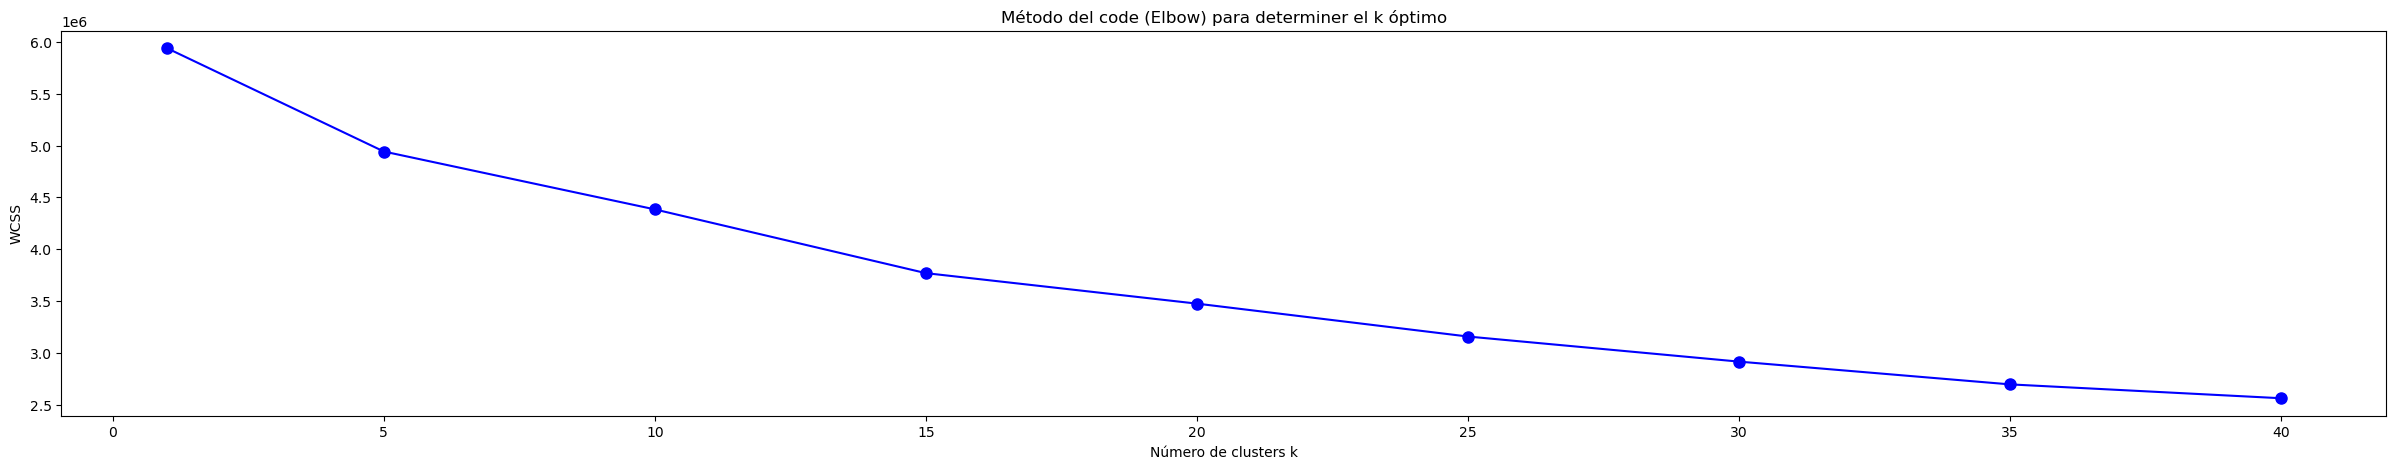

In [22]:
# 3. Determinar el mejor valor de k
wcss = []
K_range = [1,5,10,15,20,25,30,35,40] # Se define un número razonable de clusters que puedan servir

# Se calculan los datos de cluster y centroides
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(user_movie_scaled)
    wcss.append(kmeans.inertia_)

# Visualización del "codo" que indica el mejor k
plt.figure(figsize=(30,5))
plt.plot(K_range, wcss, 'bo-', markersize=8)
plt.xlabel('Número de clusters k')
plt.ylabel('WCSS')
plt.title('Método del code (Elbow) para determiner el k óptimo')
plt.show()

In [23]:
# 4. Aplicar K-Means

n_clusters = 40  # número de clusters ideal, ver 4. 
# A partir del codo 16  Wcss disminuye lentamente y no hay ganancia al añadir más
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(user_movie_scaled)

# Añadir los centroides de los clusters a los usuarios utilisateurs
user_clusters = pd.DataFrame({
    "user_id": user_movie_matrix.index,
    "cluster": clusters
})

# Comprobar el número de usuarios por cluster
print("Cantidad de usuarios por cluster :")
print(user_clusters["cluster"].value_counts())

Cantidad de usuarios por cluster :
cluster
1     534
29     39
0       1
28      1
3       1
30      1
2       1
5       1
25      1
13      1
38      1
39      1
34      1
21      1
27      1
7       1
23      1
14      1
10      1
15      1
33      1
9       1
6       1
35      1
26      1
31      1
16      1
12      1
20      1
37      1
17      1
8       1
18      1
22      1
11      1
19      1
36      1
24      1
32      1
4       1
Name: count, dtype: int64


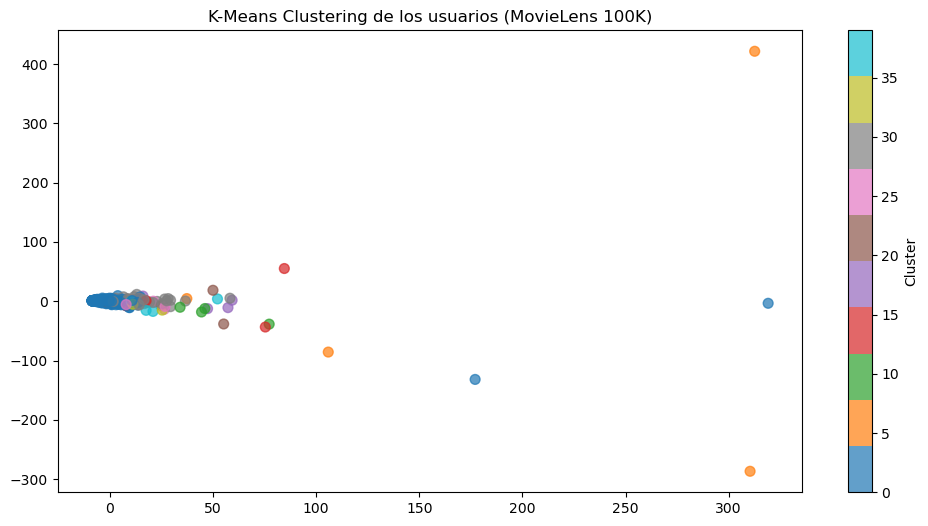

In [24]:
# 4. Reducción de la dimensión para su visualisación en dos dimensiones (usando PCA)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_movie_scaled)

plt.figure(figsize=(12, 6))
plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=clusters,
    cmap="tab10",
    s=50,
    alpha=0.7
)
plt.title("K-Means Clustering de los usuarios (MovieLens 100K)")
plt.xlabel("")
plt.ylabel("")
plt.colorbar(label="Cluster")
plt.show()